# Machine Learning with PyTorch

## Tasks with Networks

<font size="+1">A simple feature classifier</font>
<a href="NetworkExamples_0.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">An image classifier</font>
<a href="NetworkExamples_1.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1"><u><b>A regression prediction</b></u></font>
<a href="NetworkExamples_2.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Clustering with PyTorch</font>
<a href="NetworkExamples_3.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Generative Adversarial Networks (GAN)</font> 
<a href="NetworkExamples_4.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Reinforcement Learning</font>
<a href="NetworkExamples_5.ipynb"><img src="img/open-notebook.png" align="right"/></a>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# For demonstration, we can use CPU target if CUDA not available
device = torch.device('cpu')

# Check the status of the GPU (if present)
if torch.cuda.is_available():
    torch.cuda.memory_allocated()
    # *MUCH* faster to run on GPU
    device = torch.device('cuda') 

## A regression prediction

In the classification problem I took from my work about predicting garment sizes there was a simplification to try to help our DNN.  Actual sizes are two dimensional, having both a numeric size which measures "width" and a descriptor ("LONG", "SHORT", "PETITE" that measures length.  Of course, cloth is flexible, so these things interact somewhat.  In any case, the data provided only utilizes the main size component—a "number", although `00` is a special number that is different from `0` in garment sizing.

Given only those single number sizes, we can actually put them in a linear order unambiguously.  Framing it that way suggests a regression problem rather than a classification problem.  In the rest of this notebook, we construct a model that is mostly the same as the classifcation we performed before, but is constructed as a regression instead.

In [2]:
df = pd.read_csv('data/garments.csv.gz', dtype={'TARGET':str})
print(len(df))
df.head()

243570


,age,bra_size_chest,bra_size_cup,height,shoe_size,weight,TARGET
0,30.0,34.0,5.0,62.0,7.0,128.0,6
1,20.0,34.0,3.0,64.0,8.0,145.0,6
2,26.0,32.0,4.0,64.0,8.0,148.0,6
3,43.0,34.0,5.0,61.0,7.0,145.0,6
4,63.0,38.0,3.0,63.0,8.0,130.0,6


### Encoding the target

For a regression problem, we do not wish to one-hot-encode the target.  Intead, we will simply convert the linearly ordered sizes to sequential integers.  These are, strictly speaking, ordinal rather than quantitative values, but it does not matter very much for this construction I.e. size `8` is not "twice as much" as size `4` in any measure, nor is it so in the integer sequence encoding; `8` is simply *more than* `4` to some degree.

In [3]:
X = df[['age', 'bra_size_chest', 'bra_size_cup', 'height', 'shoe_size', 'weight']]

sizes = ['00', '0', '2', '4', '6', '8', '10', '12', '14', '16', '18']
size_to_num = dict(zip(sizes, range(len(sizes))))
num_to_size = {v:k for (k, v) in size_to_num.items()}

y = df.TARGET.map(size_to_num)
y.head()

0    4
1    4
2    4
3    4
4    4
Name: TARGET, dtype: int64

The only real difference in setting up the layer sizes is that the output dimension is one rather than a larger number of one-hot-encoded elements.

In [4]:
# The number of input features
in_dim = X.shape[1]

# The number of "polynomial features" of order 2
hidden1 = int(in_dim * 2 + (in_dim * (in_dim-1) / 2) + 1)
out_dim = 1

# The sizes of the "inference layers"/
hidden2 = hidden3 = hidden4 = 2 * len(y.unique())  

# Remind ourselves of the layer sizes
in_dim, hidden1, hidden2, hidden3, hidden4, out_dim

(6, 28, 22, 22, 22, 1)

### Customizing the training regime

For the most part, the code in `do_training()` is the same as we used previously.  However, a lot of trial and error went into tweaking the learning rate decay to be "pretty good" for this problem.  Batches and epochs are trained *much* more quickly with this simplified target; but at the same time, it takes many more epochs for loss to reach a stable valley than it did with the classification version.

In [5]:
def do_training(model, X_train, Y_train, optimizer, loss_fn, 
                epochs=5000, batch_size=5000, early_stop=6):
    loss_history = []
    print("+++ Beginning %d epochs with batch size %d" % (epochs, batch_size))
    for epoch in range(1, epochs+1):
        new_epoch = True
        for start in range(0, len(X_train), batch_size):
            # Next batch of training rows
            X = X_train[start:start+batch_size]
            Y = Y_train[start:start+batch_size]

            # Forward pass: compute predicted Y by passing X to the model.
            Y_pred = model(X)

            # Compute and print loss.
            loss = loss_fn(Y_pred, Y)
            if new_epoch:
                print("Epoch %d; Loss: %0.6f (lr=%0.8f)" % (
                        epoch, loss.item(), optimizer.param_groups[0]['lr']))
                new_epoch = False
                loss_history.append(loss.item())
                
            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable
            # weights of the model). This is because by default, gradients are
            # accumulated in buffers( i.e, not overwritten) whenever .backward()
            # is called. Checkout docs of torch.autograd.backward for more details.
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            optimizer.step()
                    
        # Is this regime currently failing to reduce loss?
        ## Run for at least `early_stop` epochs
        if len(loss_history) < early_stop:
            continue
            
        ## Lower learning rate by 2x if no improvement in loss for multiple epochs
        diff = max(loss_history[-early_stop:]) - min(loss_history[-early_stop:])
        if  diff/loss_history[-1] < 0.005:
            optimizer.param_groups[0]['lr'] /= 2
            
        ## If learning rate is lowered to tiny value, we are not getting anywhere
        if optimizer.param_groups[0]['lr'] < 1e-8:           
            print("+++ Discontinuing training regime when loss becomes constant")
            break

### Defining the model

The only thing different in this model versus that used in the classifier is that the final layer has a single output, and there is no activation function applied to it.  This gives us a regression instead.  Perhaps not the optimal one possible, but at least framed the right way.

In [6]:
# Create a sequential NN
model = torch.nn.Sequential(
    # This layer allows "polynomial features"
    torch.nn.Linear(in_dim, hidden1),
    # The activation is treated as a separate layer
    torch.nn.ReLU(),

    # This layer is "inference"
    torch.nn.Linear(hidden1, hidden2),
    torch.nn.ReLU(), 
    
    # A Dropout layer sometimes reduces co-adaptation of neurons
    torch.nn.Dropout(p=0.1),

    # This layer is "inference"
    torch.nn.Linear(hidden2, hidden3),
    # Often Leaky ReLU eliminates the "dead neuron" danger
    torch.nn.LeakyReLU(), 
    
    # Might try another "inference" layer
    torch.nn.Linear(hidden3, hidden4),
    torch.nn.LeakyReLU(), 

    # A basic linear layer with one output for the "continuous" target 
    torch.nn.Linear(hidden4, out_dim),  
    ).to(device)

### Split the data, summarize the model

In [7]:
# Free up the GPU
torch.cuda.empty_cache()
print("Just the model itself:")
print(f"{torch.cuda.memory_allocated():,} bytes allocated on GPU")

# Split the original data
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Convert arrays to tensors
X_train = torch.from_numpy(X_train.values).float().to(device)
X_test  = torch.from_numpy(X_test.values).float().to(device)
y_train = torch.from_numpy(y_train.values)[:, np.newaxis].float().to(device)
y_test  = torch.from_numpy(y_test.values)[:, np.newaxis].float().to(device)

print("Add the training and testing data to GPU:")
print(f"{torch.cuda.memory_allocated():,} bytes allocated on GPU")

Just the model itself:
10,752 bytes allocated on GPU
Add the training and testing data to GPU:
7,014,912 bytes allocated on GPU


In [8]:
from torchsummary import summary
summary(model, input_size=(1, X_train.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 28]             196
              ReLU-2                [-1, 1, 28]               0
            Linear-3                [-1, 1, 22]             638
              ReLU-4                [-1, 1, 22]               0
           Dropout-5                [-1, 1, 22]               0
            Linear-6                [-1, 1, 22]             506
         LeakyReLU-7                [-1, 1, 22]               0
            Linear-8                [-1, 1, 22]             506
         LeakyReLU-9                [-1, 1, 22]               0
           Linear-10                 [-1, 1, 1]              23
Total params: 1,869
Trainable params: 1,869
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total

### Train the model

This will run for quite a few epochs.  On a good GPU, each epoch completes very quickly though.

In [9]:
%%time
## Now run model (start with high learning rate and decay)

loss_fn = torch.nn.SmoothL1Loss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
do_training(model, X_train, y_train, optimizer, loss_fn)

+++ Beginning 5000 epochs with batch size 5000
Epoch 1; Loss: 4.072652 (lr=0.00010000)
Epoch 2; Loss: 3.049572 (lr=0.00010000)
Epoch 3; Loss: 1.920147 (lr=0.00010000)
Epoch 4; Loss: 1.103271 (lr=0.00010000)
Epoch 5; Loss: 1.000879 (lr=0.00010000)
Epoch 6; Loss: 0.995870 (lr=0.00010000)
Epoch 7; Loss: 0.958177 (lr=0.00010000)
Epoch 8; Loss: 0.932585 (lr=0.00010000)
Epoch 9; Loss: 0.900398 (lr=0.00010000)
Epoch 10; Loss: 0.867173 (lr=0.00010000)
Epoch 11; Loss: 0.846460 (lr=0.00010000)
Epoch 12; Loss: 0.798907 (lr=0.00010000)
Epoch 13; Loss: 0.773657 (lr=0.00010000)
Epoch 14; Loss: 0.760428 (lr=0.00010000)
Epoch 15; Loss: 0.745389 (lr=0.00010000)
Epoch 16; Loss: 0.717555 (lr=0.00010000)
Epoch 17; Loss: 0.698719 (lr=0.00010000)
Epoch 18; Loss: 0.696546 (lr=0.00010000)
Epoch 19; Loss: 0.683856 (lr=0.00010000)
Epoch 20; Loss: 0.678284 (lr=0.00010000)
Epoch 21; Loss: 0.673322 (lr=0.00010000)
Epoch 22; Loss: 0.657138 (lr=0.00010000)
Epoch 23; Loss: 0.656391 (lr=0.00010000)
Epoch 24; Loss: 0.6

### Visualizing the predictions

Our regression approach, we cannot determine any prediction probabilities.  In some ways, this is an advantage because we do not get discontinuities between a "best guess" and a "second guess" as we saw in the classification approach.  As a domain matter, the second guess should almost surely be "a little bit smaller" or a "a little bit larger" than the best guess.

However, that simplification relies on our prior simplification of the target to ordinal values.  In the two dimensional sizing of the original garments, it is harder to say precisely what "next largest" or "next smallest" mean.  The visualization below simply makes a large number of predictions, and maps each point with an X-axis of the "ground truth" and a Y-axis of the prediction.  The predictions are continuous values, but those could easily be rounded to integers in the mapped range to make an actual garment size prediction.

Notice that some predictions are of numeric values greater than 10 (the ordinal encoding of size `18`).  That would be fine with an rounding-to-ordinal rule though.  If the predictions were perfect, all the blue circles would lie on top of the red line.  The actual model is much worse than that.  It seems to do better than the classifier in some ways, but to a lesser degree also under-predicts the largest and smallest sizes, favoring middle sizes.  Moreover, the spread of predictions around the ground truth is not yet especially tight.

Do you have ideas for approaches to improve these predictions?

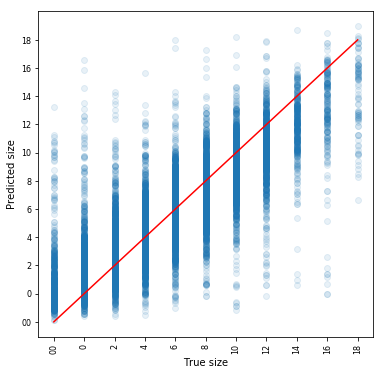

In [10]:
from numpy.random import randint
labels = size_to_num.keys()

ndxs = randint(0, len(X_test), 10_000)
predictions = [p.item() for p in model(X_test[ndxs])]
truths = [t.item() for t in y_test[ndxs]]

plt.figure(figsize=(6, 6))
plt.scatter(truths, predictions, marker='o', alpha=0.1)
plt.xticks(range(len(labels)), labels, fontsize=8, rotation='vertical')
plt.yticks(range(len(labels)), labels, fontsize=8)
plt.xlabel("True size")
plt.ylabel("Predicted size")
ref = np.linspace(0, 10, 100);
plt.plot(ref, ref, color="red");

## Next Lesson

**Tasks with Networks**: This lesson constructed a basic regression model, with moderately good success in its domain.  Next we will look at unsupervised learning and perform clustering with PyTorch neural networks.

<a href="NetworkExamples_3.ipynb"><img src="img/open-notebook.png" align="left"/></a>